In [1]:
#Script to segment flow images. It requires 4 data sets: 1: the dry image for registration, 2: the flow image, 3: the wet image, and 4: the segmented dry scan 

#files needed to run the processing. NB utils is a package that Dane helped me make. It includes some important functions in it. 
import utils
import skimage
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw

#non-local means filter 
from skimage import data, img_as_float, img_as_ubyte, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

#registration
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft

#dealing with saving tif files 
import os
import tifffile as tif
import ipywidgets as widgets


# Dry scan needed for registration 

In [2]:
# note we are loading in fewer slices to save memory, it seems sufficient, but could be changed
# can we apply the same transform once we know what the reference is? This will save computation 


# Read the TIFF images for the dry scan 
dry_data  = skimage.io.imread('E:\\CatHarris\\Nihal\\Dry_3.tif')


# convert to a 3D array and normalise so data is between 0 and 1 
dry_data  = np.asarray(dry_data) 
dry_data = (dry_data - dry_data.min()) / (dry_data.max() - dry_data.min()) * 255
dry_data  = dry_data.astype(np.uint8)


### Load wet scan (flow done in the loop later on)

In [4]:

# Read the TIFF images for the dry scan 
wet_data  = skimage.io.imread('E:\\CatHarris\\Nihal\\Brine_3.tif')


# convert to a 3D array and normalise so data is between 0 and 1 
wet_data  = np.asarray(wet_data) 
wet_data = (wet_data - wet_data.min()) / (wet_data.max() - wet_data.min()) * 255
wet_data  = wet_data.astype(np.uint8)

### Filtering and registration 

In [5]:
#filter the images prior to registration

#non-local means filter works better on float of image with no exposure or histogram modification.
dry_float  = dry_data.astype(np.float32)
wet_float  = wet_data.astype(np.float32)
del dry_data # this is done to minmise memory usage 
del wet_data

def nlm_denoise(Img,patch,dist):
    
    def nlm_denoise_wrap(array):
        correct=img_as_float(array[0])
        sigma_est = np.mean(estimate_sigma(correct))
        correct = denoise_nl_means(correct, h=3 * sigma_est, sigma=sigma_est,fast_mode=True,patch_size=patch, patch_distance=dist)
        return correct[np.newaxis, ...]
    
    denoise=skimage.util.apply_parallel(nlm_denoise_wrap,Img, chunks=(1, Img.shape[1],Img.shape[2]), dtype='float',compute=True)
    
    return  denoise

denoise_dry = nlm_denoise(dry_float, patch = 3,  dist = 6)

denoise_wet = nlm_denoise(wet_float, patch = 3,  dist = 6)
del wet_float






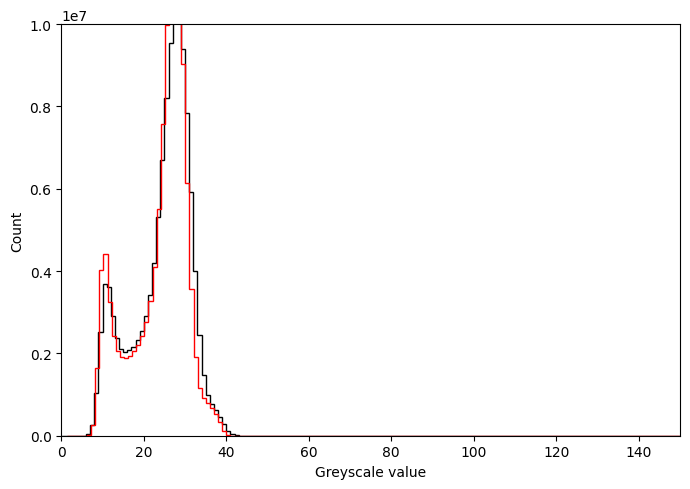

In [6]:
#denoise_dry  = utils.preprocess(denoise_dry.astype(np.uint8))
#denoise_wet  = utils.preprocess(denoise_wet.astype(np.uint8))


#plot of the histograms (entire image, not the zoomed in image)
bins=255
fig, ax = plt.subplots(figsize =(7, 5))
ax.set_xlabel('Greyscale value')
ax.set_ylabel('Count')

ax.set_xlim(0, 150) 
ax.set_ylim(0, 10**7) 

ax.hist(dry_float.ravel(), bins=bins, histtype='step', color='black')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

ax.hist(denoise_dry.ravel(), bins=bins, histtype='step', color='red')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

fig.tight_layout()
plt.show()

del dry_float


Shift in Z direction for wet scan [1. 3. 1.]


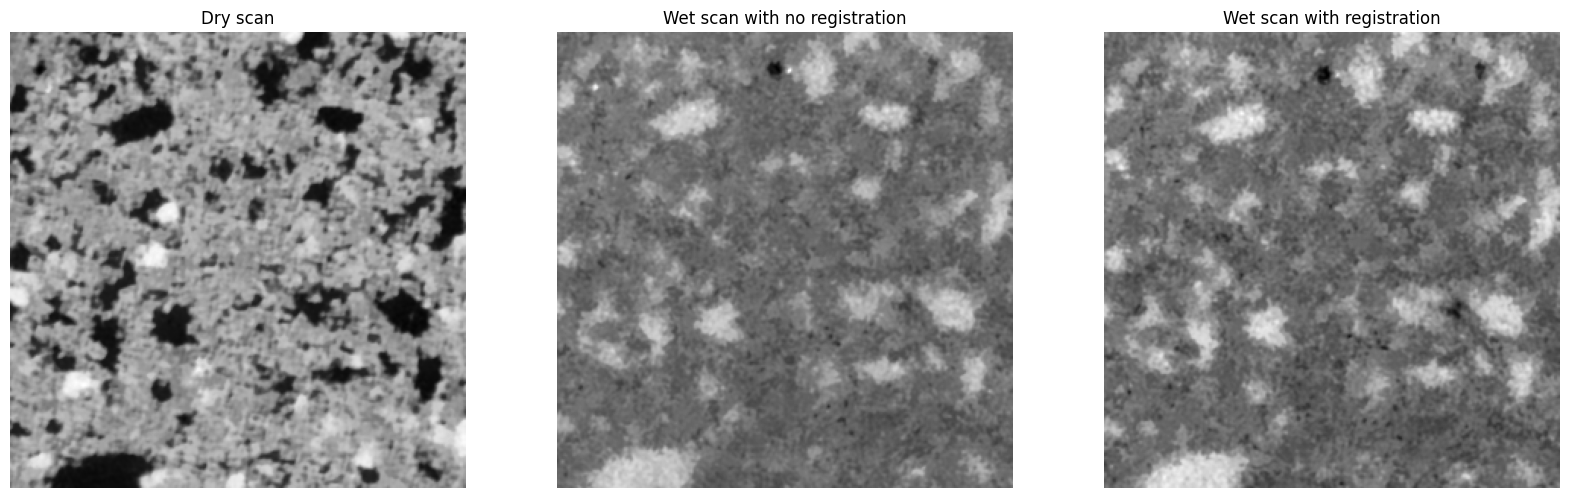

(496, 498, 496)


In [40]:
#registration for the wet scan (done once and then applied to the flow image)
# pixel precision 
shift_wet, error_wet, diffphase_wet = phase_cross_correlation(denoise_dry[:, ...], denoise_wet[:, ...])
print('Shift in Z direction for wet scan', shift_wet)
#Check the registration 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(denoise_dry[10, 100:400, 100:400],cmap='gray')
ax[0].axis('off')
ax[0].set_title('Dry scan')


ax[1].imshow(denoise_wet[10, 100:400, 100:400],cmap='gray')
ax[1].axis('off')
ax[1].set_title('Wet scan with no registration')

ax[2].imshow(denoise_wet[10 -1 , 100-3:400-3, 100-1:400-1],cmap='gray')
ax[2].axis('off')
ax[2].set_title('Wet scan with registration')
plt.show()

#simple 3D shift, no resampling of the axes needed with this, but could be adapted 

denoise_wet_reg  = denoise_wet[5-int(shift_wet[0]):, 5-int(shift_wet[1]):, 5-int(shift_wet[2]):] 
print(denoise_wet_reg.shape)

### Filter and register the flow images separately so we can loop over this part separately 

Shift in Z direction for flow scan [ 3.  4. -3.]


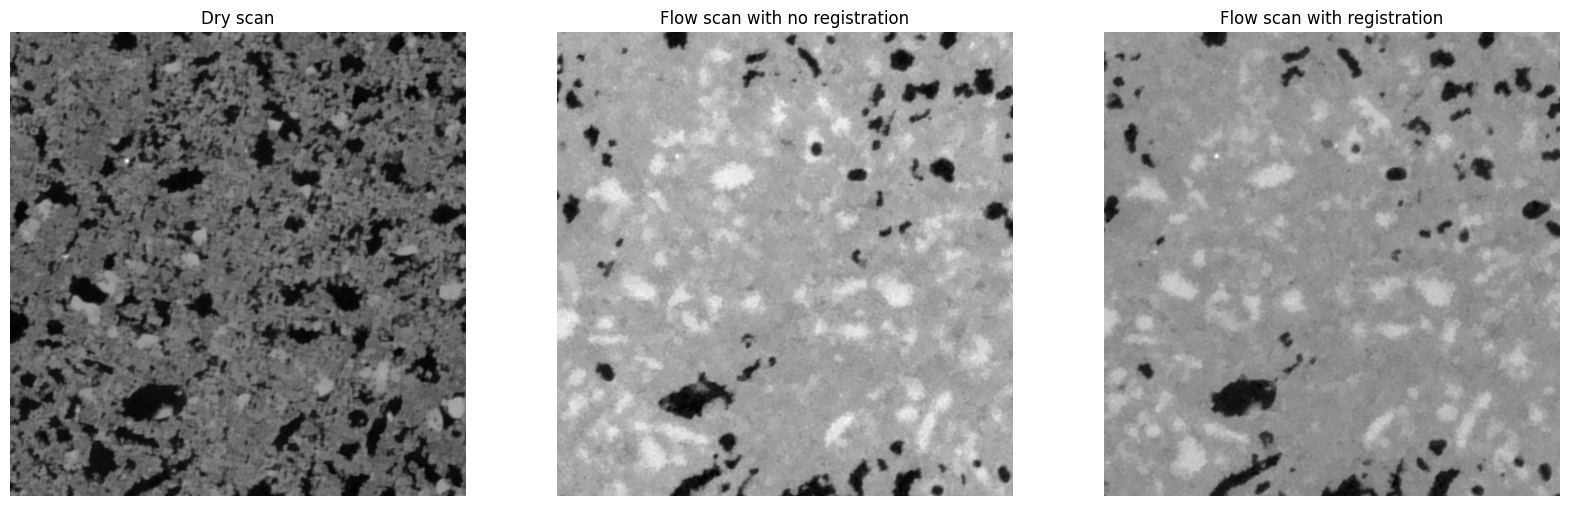

In [44]:

# Read the TIFF images for the dry scan 
flow_data  = skimage.io.imread('E:\\CatHarris\\Nihal\\F-0.75_3.view.tif')


# convert to a 3D array and normalise so data is between 0 and 1 
flow_data  = np.asarray(flow_data) 
flow_data = (flow_data - flow_data.min()) / (flow_data.max() - flow_data.min()) * 255
flow_data  = flow_data.astype(np.uint8)

#filtering
flow_float = flow_data.astype(np.float32)
del flow_data
denoise_flow = nlm_denoise(flow_float, patch = 3,  dist = 6)
del flow_float
denoise_flow = denoise_flow.astype(np.uint8)

#registration
shift, error, diffphase = phase_cross_correlation(denoise_dry, denoise_flow)
#shift[0] = -2
print('Shift in Z direction for flow scan', shift)
denoise_flow_reg = denoise_flow[(5 - int(shift[0])): denoise_wet_reg.shape[0] + 1, (5 - int(shift[1])): denoise_wet_reg.shape[1] + 1, (5 - int(shift[2])): denoise_wet_reg.shape[2] + 1] 



#Check the registration 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(denoise_dry[13,:, :],cmap='gray')
ax[0].axis('off')
ax[0].set_title('Dry scan')


ax[1].imshow(denoise_flow[13,:, :],cmap='gray')
ax[1].axis('off')
ax[1].set_title('Flow scan with no registration')

ax[2].imshow(denoise_flow_reg[8,:, :],cmap='gray')
ax[2].axis('off')
ax[2].set_title('Flow scan with registration')
plt.show()





def simple_thresholding(img: np.array, min_threshold: float, max_threshold: float) -> np.array:
    bins=255
    # find where histogram goes to 0 for the brine 
    hist_values = img[:, :, :].ravel()
    hist_bincount = np.bincount(hist_values)
    end_brine     = np.argmax(hist_bincount<2000)

    threshold_img = ((img.max() - img.min()) * min_threshold + img.min() <= img) & (img <= (img.max() - img.min()) * max_threshold + img.min())
    threshold_img = np.array(threshold_img, dtype=np.bool8)

    assert len(threshold_img.shape) == 3  # rgb
    return threshold_img



 

In [59]:

#make the arrays the same shape if the shifts are different 
denoise_flow_reg    = denoise_flow_reg[0: denoise_wet_reg.shape[0]-5, 0: denoise_wet_reg.shape[1]-5, 0: denoise_wet_reg.shape[2]-5].astype(np.uint8)
denoise_wet_reg_seg = denoise_wet_reg[0: denoise_flow_reg.shape[0], 0: denoise_flow_reg.shape[1], 0: denoise_flow_reg.shape[2]].astype(np.uint8)

#subtration of the flow scan with the wet scan 
just_gas = denoise_flow_reg.astype(np.uint8) - denoise_wet_reg_seg.astype(np.uint8)


#simple thresholding segmentation 
gas_v1         = simple_thresholding(just_gas, min_threshold=0, max_threshold = 0.45) 
filtered_gasv1 = skimage.morphology.remove_small_objects(gas_v1, min_size=4)    
filtered_gasv1 = skimage.morphology.remove_small_holes(filtered_gasv1, area_threshold=4)    


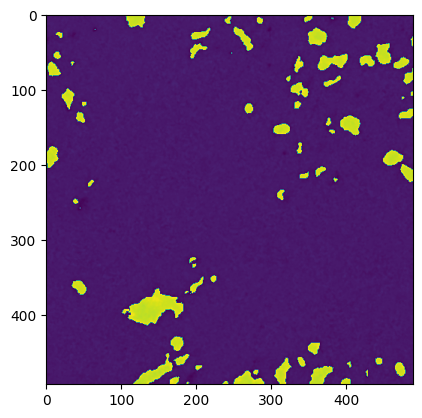

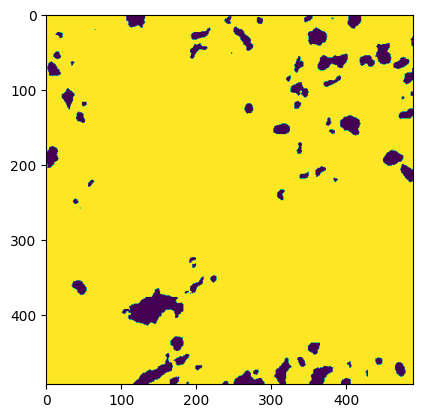

In [65]:
plt.imshow(just_gas[10, ...])
plt.show()
plt.imshow(gas_v1[10, ...])

In [62]:

#load in the segmented dry image 

segmented_dry = skimage.io.imread('E:\\CatHarris\\Nihal\\Nihal_dry_v2.tif')
segmented_dry = segmented_dry[5:5+denoise_flow_reg.shape[0], 5:5+denoise_flow_reg.shape[1], 5:5+denoise_flow_reg.shape[2]]

# Use the mask to get the location of the water 
segmented_wet = utils.mask_with_dry(filtered_gasv1 == 0, segmented_dry==1)
masked_gas    = utils.mask_with_dry(filtered_gasv1 == 1, segmented_dry==1)


segmented_flow = segmented_wet + (masked_gas * 2)



#simple 3D shift, no resampling of the axes needed with this, but could be adapted 



In [68]:
denoise_dry_reg = denoise_dry[5:5+denoise_flow_reg.shape[0], 5:5+denoise_flow_reg.shape[1], 5:5+denoise_flow_reg.shape[2]]
print(denoise_dry.shape, segmented_dry.shape, denoise_flow_reg.shape, segmented_flow.shape)
#saving the tiff image 
os.chdir(r'E:\\CatHarris\\Nihal\\')
tif.imwrite('segmented_flow_registered.tif', segmented_flow, bigtiff=True)
tif.imwrite('flow_registered.tif', denoise_flow_reg, bigtiff=True)
tif.imwrite('dry_scan_registered.tif', denoise_dry_reg, bigtiff=True)
tif.imwrite('segmented_dry_scan_registered.tif', segmented_dry, bigtiff=True)


(500, 500, 500) (491, 493, 489) (491, 493, 489) (491, 493, 489)


### Check the success of registration 

In [66]:

z_widget = widgets.IntSlider(
    value=2,
    min=0,
    max=10,
    step=1,
)


overlay_widget = widgets.RadioButtons(
    options=[True, False],
    description='Overlay:',
    disabled=False,
)


def view_slice(img: np.ndarray, z: int, overlay: bool, mask: bool) -> None:
    depth, h, w = img.shape
    assert isinstance(img, np.ndarray)
    assert isinstance(z, int)
    assert isinstance(overlay, bool)
    assert 0 <= z < depth

    slice_o = img[z, :, :]

    if overlay:
        slice = utils.preprocess(slice_o)
        mask  = mask[z, :, :]
        slice = utils.sanity_check(slice, mask)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

    ax[0].imshow(slice,cmap='gray')
    ax[0].axis('off')


    ax[1].imshow(slice_o,cmap='gray')
    ax[1].axis('off')
    plt.show()



widgets.interact(view_slice, img=widgets.fixed(denoise_flow_reg[:, :,:]), z=z_widget, overlay=overlay_widget, mask = widgets.fixed(segmented_wet[:, :,:]==0))

interactive(children=(IntSlider(value=2, description='z', max=10), RadioButtons(description='Overlay:', option…

<function __main__.view_slice(img: numpy.ndarray, z: int, overlay: bool, mask: bool) -> None>

### Merging code

In [2]:
# Code that reads in the segmented file and then matches the slice and saves as one large one 
# for middle, missing middle and top 

directory = 'E:\\New reconstructions\\segmented\\'

folders = (os.listdir(os.path.join(directory, 'bottom_redone')))
i = 1

#read in bottom
im_bottom          = skimage.io.imread(os.path.join(directory, 'bottom_redone', folders[i]))
im_bottom          = im_bottom.astype(np.uint8) 

#read in middle
im_middle          = skimage.io.imread(os.path.join(directory, 'middle_redone', folders[i]))
im_middle          = im_middle.astype(np.uint8) 

#read in extra middle
im_middle2          = skimage.io.imread(os.path.join(directory, 'top_redone', folders[i]))
im_middle2          = im_middle2.astype(np.uint8) 

#read in top
im_top          = skimage.io.imread(os.path.join(directory, 'extra_top_redone', folders[i]))
im_top          = im_top.astype(np.uint8) 

    
#find matching slice 
for k in range(0, im_middle.shape[0]): 
    diff = im_middle[k, :, :] - im_bottom[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=10) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged = np.append(im_bottom[:,:,:], im_middle[k+1:, :, :], axis = 0)
        print('Matching slice, merge', k)
        break 

print(merged.shape)

#find matching slice 
for j in range(0, im_middle2.shape[0]): 
    diff = im_middle2[j, :, :] - merged[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=10) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged1 = np.append(merged[:,:,:], im_middle2[j+1:, :, :], axis = 0)
        print('Matching slice, merge1', j)
        break 

print(merged1.shape)


#find matching slice 
for m in range(0, im_top.shape[0]): 
    diff = im_top[m, :, :] - merged1[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=10) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged3 = np.append(merged1[:,:,:], im_top[m+1:, :, :], axis = 0)
        print('Matching slice, merge2', m)
        break 

print(merged3.shape)


os.chdir(r'E:\\New reconstructions\\segmented\\fully_segmented')
tif.imwrite('merged_{}'.format(folders[i]), merged3, bigtiff=True)

Matching slice, merge 51
(1102, 1400, 1400)
Matching slice, merge1 51
(1627, 1400, 1400)
Matching slice, merge2 26
(1866, 1400, 1400)
